<span style="color:#333333; font-size:24px; font-weight:bold"> Statistical Analysis by <a href=https://github.com/cyterat style="color:#00b2b7;">cyterat</a></span>

<img src="https://pwimages-a.akamaihd.net/arc/6d/07/6d070b0efab67dfa6cee67e718653c271430891855.png"></img>

# Important Notice
**The original analysis contained Personal Identifiable Information (PII).**

**The structured report containing the analysis summary and visualizations was done separately.**

**The list below shows changes made after the analysis originaly took place, to share the notebook publicly (github & portfolio website):**
- Removed guild name
- Removed guild logo
- Added function masking character names and account names
- Added function masking custom guild ranks

**Unrelated to PII changes:**
- Changed headers
- Deleted redundant code cells and added comments
- Changed some code and re-ran the notebook to support newer Python version
- Created 2 separate notebooks with eda and statistical analysis 

# Contents
1. [Variables Overview](#Variables-(based-on-EDA))
2. [Outliers](#Outliers-(contribution))
3. [Guild Rank and Contribution](#Guild-Rank-and-Contribution)
    1. [Correlation](#Correlation-Between-Guild-Rank-and-Contribution)
    2. [Difference Between Ranks](#Difference-Between-Ranks)
        1. [Transformation/Scaling (Contributions)](#Transformation/Scaling-(Contributions))
        2. [Kruskal-Wallis H-test](#Kruskal-Wallis-H-test)
        3. [Post-Hoc-Dunn's-Test-with-Bonferroni-Correction](#Post-Hoc-Dunn's-Test-with-Bonferroni-Correction)
        4. [Post-Hoc Summary](#Post-Hoc-Summary)
    3. [Expected vs Observed Contribution per Rank](#Expected-vs-Observed-Contribution)
        1. [Logistic Regression](#Logistic-Regression:-y=contribution-(binary),-x=guild_rank-(ordinal))
        2. [Model Validation](#Model-Validation)
        3. [Results Visualization](#Results-Visualization)
        4. [Summary](#Summary)
        5. [Usage Examples](#Usage-Examples)
***

In [1]:
import os
import warnings
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.patheffects as patheffects
import seaborn as sns

import pingouin as pg
import statsmodels.formula.api as smf
from scikit_posthocs import posthoc_dunn
from scipy.stats import chi2

from scipy.stats.mstats import winsorize
from scipy.stats import skew
from sklearn.preprocessing import StandardScaler

In [2]:
warnings.filterwarnings("ignore")

In [3]:
pd.options.display.max_columns = 99
pd.options.display.float_format = '{:.2f}'.format

In [4]:
nw_clr_single = '#f56504'
nw_clr_single_greyed = '#cca299'

In [5]:
file = os.path.join('data','guild-member-list-281221-clean.csv')

In [6]:
custom_date_parser = lambda x: datetime.strptime(x, "%m/%d/%Y %H:%M:%S %p")

In [7]:
df_guild = pd.read_csv(
    file,
    converters={'Last Active Date': custom_date_parser}
)
df_guild.head(1)

,character,account,character_class,guild_rank,contribution,last_active_date,days_inactive
0,wdSwoh,o9r2nornddr@cr,Rogue,6,485165,2021-12-28 09:50:03,0


# Variables (based on EDA)

- __character__ -- cat. nominal -- ID;
- __account__ -- cat. nominal -- ID;
- __character_class__ -- cat. nominal -- 9 classes;
- __guild_rank__ -- cat. ordinal -- 7 ranks, 1 is the lowest rank;
- __contribution__ -- num. discrete;
- __days_inactive__ -- num. discrete; 

__To-Do__

- Decide on how to deal with large contribution values (potential outliers).
- Measure correlation between guild ranks and contribution, and check statistical significance.
- Check if there are statistically significant differences in contribution between guild ranks.
    - If differences exist, conduct Post-Hoc test to find which ranks exactly are different and to what extent.
    - If differences exist, use regression analysis to further explore the relationship.
- Create visualizations and explanations/comments/conclusions, to make findings more accessible.

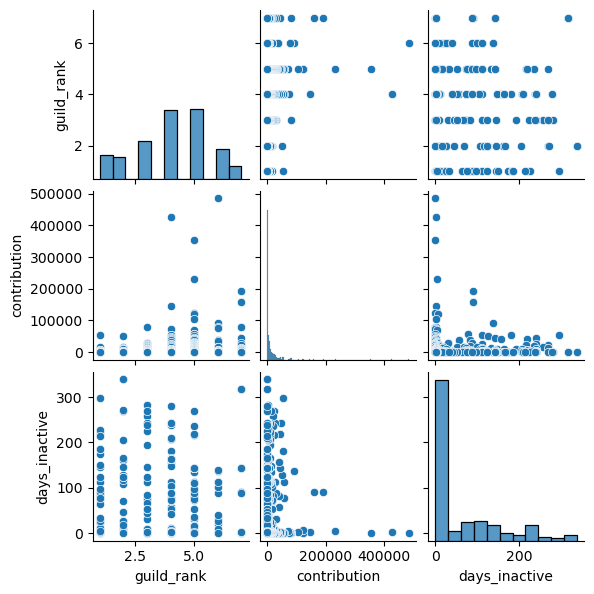

In [8]:
sns.pairplot(df_guild, height=2);

In [9]:
df_guild.describe(percentiles=[.999,.99,.95,.90]).style.format(precision=0, thousands=',')

,guild_rank,contribution,days_inactive
count,334,334,334
mean,4,"15,625",63
std,2,"47,332",89
min,1,0,0
50%,4,"1,875",5
90%,6,"37,610",218
95%,6,"61,467",242
99%,7,"217,475",332
99.9%,7,"465,410",339
max,7,"485,165",339


__Notes:__
- Data overall seems to be mostly discrete by nature and doesn't assume continuity.
- Contribution variable doesn't seem to follow a normal distribution, has a substantial amount of zero values, and large variance.
- The dataset represents population of the guild.
- The Bard class has a small sample size, therefore it should not be used to make any strong conclusions.

# Outliers (contribution)

Among different (simple) outlier removal/detection techniques like using iqr, z-score, percentiles, I decided to use __winsorization, right side only, capping at 95%__.

__Reasons:__

- Why not keeping large values? Current statistical analysis is not being performed on a character level but rather to find general trends and relationships, i.e. knowing that character A has 400k contribution, while median across all records is ~2k and 95% of values are below ~61k, does not introduce any meaningful information.

- Why winsorization? Winsorization helps to preserve character data alongside the "effect" of a large contribution (e.g. contribution of 400k will be replaced with 60k).
  
- Why capping at 95%? The choice of capping at 95% is based on the "jump" between 95th and 99th percentile of contribution which can be seen further above, 61,467 and 217,475 respectively.

  
- Why not winsorizing left side? The right side only cap is chosen because, although contribution is zero inflated, these zeros are not outliers, they represent a lack of contributions (inactivity). Therefore, winsorizing left side might falsely inflate these values, e.g. from 0 to 1,000, leading to false conclusions.

__Important Notice:__
Contribution doesn't always equal high in-game activity, it simply shows how engaged a particular character is in a guild "life". A character might have low contribution but be highly active in other in-game activities. 

### Winsorization

In [10]:
df_guild['contribution'].max(), df_guild['contribution'].std()

(485165, 47331.590431231714)

In [11]:
winsorize(df_guild['contribution'], limits=[0.0, 0.05]).max(), winsorize(df_guild['contribution'], limits=[0.0, 0.05]).std()

(70862, 18404.425945981984)

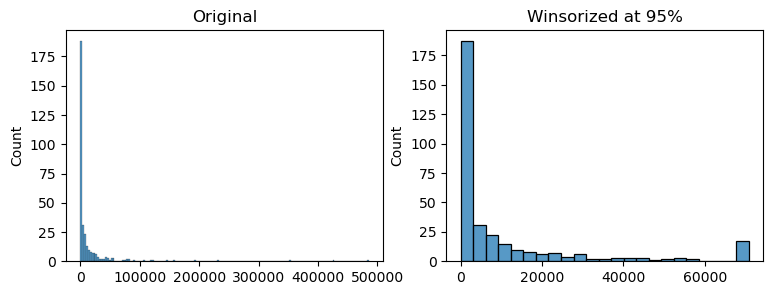

In [12]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(9,3))

sns.histplot(winsorize(df_guild['contribution']), ax=ax1).set_title('Original')
sns.histplot(winsorize(df_guild['contribution'], limits=[0.0, 0.05]), ax=ax2).set_title('Winsorized at 95%')
plt.show()

Choosing winsorization has proved to be a good decision, which helped to preserve a noticeable amount of high contributors and cap at a relatively acceptable value.

In [13]:
df_guild_wins = df_guild.copy()
df_guild_wins['contribution'] = winsorize(df_guild['contribution'], limits=[0.0, 0.05]).data
df_guild_wins.describe()

,guild_rank,contribution,days_inactive
count,334.00,334.00,334.00
mean,4.05,10568.28,62.65
std,1.56,18432.04,88.58
min,1.00,0.00,0.00
25%,3.00,0.00,1.00
50%,4.00,1875.00,5.00
75%,5.00,11080.00,112.00
max,7.00,70862.00,339.00


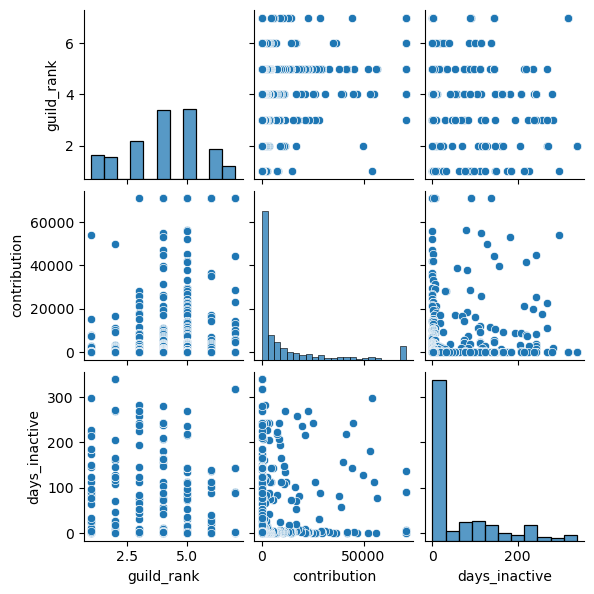

In [14]:
sns.pairplot(df_guild_wins, height=2);

# Guild Rank and Contribution

A single account (player) might have several different characters (alts). The ranks across all of these characters could differ. It might be either due to an officer's mistake or player not requesting a rank update for their alt. 

This means, that Character-level analysis, i.e. group by character, can potentially lead to incorrect conlusions. Which is why, I will group characters by account (Account-level), thus ensuring that I am measuring player engagement rather than character usage patterns.

In [15]:
df_guild_wins_acc = (
    df_guild_wins
    .groupby('account', as_index=False)
    .agg({'guild_rank':max,'contribution':sum})
    .drop(columns='account')
    .copy()
)
print(df_guild_wins_acc.shape)
df_guild_wins_acc.head(2)

(136, 2)


,guild_rank,contribution
0,2,2436
1,3,2100


## Correlation Between Guild Rank and Contribution
Below is a quick correlation overview to see whether __guild rank__ and __contribution__ variables have a directional relationship.

Non-Parametric, Spearman's correlation is chosen here because it doesn't assume normality or linear relationship, and feels ok around extreme values. Moreover, guild rank is an ordinal categorical variable which is one of the assumptions for the test.

In [16]:
(
    df_guild_wins_acc
    .corr(method='spearman', numeric_only=True)
    .style.background_gradient(vmin=0.2)
    .format(precision=2)
)

,guild_rank,contribution
guild_rank,1.00,0.64
contribution,0.64,1.00


In accordance with the generally accepted interpretations, spearman rho of 0.8 is considered strong, 0.6 is moderate, and 0.2 is a weak relationship.

The results above suggest there is a moderate positive relationship between __Guild Rank__ and __Contribution__, which is an interesting finding that requires further examination.

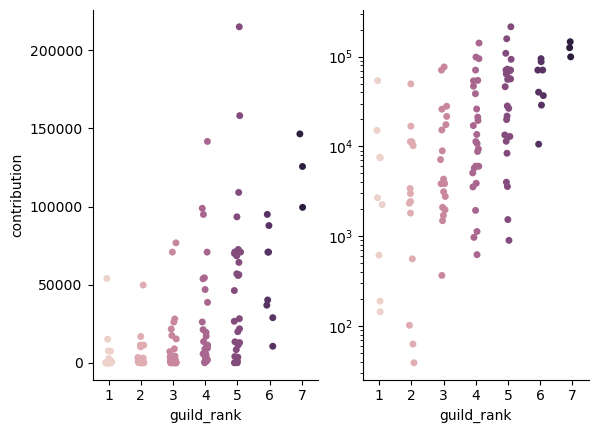

In [17]:
fig, (ax1,ax2) =  plt.subplots(1,2, sharex=True)

sns.stripplot(ax=ax1, x='guild_rank', y='contribution', data=df_guild_wins_acc, hue='guild_rank', legend=False, jitter=True)
sns.stripplot(ax=ax2, x='guild_rank', y='contribution', data=df_guild_wins_acc, hue='guild_rank', legend=False, jitter=True)

ax2.set_yscale('log')
ax2.set_ylabel('')

sns.despine()

There exists a visible upward trend in contributions as guild rank increases, mainly on a visualization with log transformed contribution. However, number of players witin each group is visibly smaller at higher ranks.

I will proceed with a correlation test to check if the relationship between variables is statistically significant.

    Hypothesis Statement:

    H0: r = 0, There is no correlation between Guild Rank and Contributions
    H1: r != 0, There is correlation between Guild Rank and Contributions
    
    alpha = 0.05

In [18]:
pg.corr(df_guild_wins_acc['guild_rank'], df_guild_wins_acc['contribution'], method='spearman')

,n,r,CI95%,p-val,power
spearman,136,0.64,"[0.53, 0.73]",0.00,1.00


I will also compute a bootstrapped CI for a more comprehensive view. 

In [19]:
pg.compute_bootci(
    x=df_guild_wins_acc['guild_rank'],
    y=df_guild_wins_acc['contribution'],
    func='spearman',
    paired=True,
    n_boot=1000
)

array([0.53, 0.74])

#### Correlation Summary
- __p-value__ shows the relationship is __statistically significant__, at alpha=0.05;
- __Confidence Interval (CI)__, including the bootstrapped, doesn't include 0, and is positive, meaning that __guild rank and contribution have a positive correlation__ at 95%CI;
- __r (rho)__ of ~0.6 shows that the relationship is moderate.

The assumption might be that as guild rank increases so does the amount of contributions. This is a logical conclusion since contribution data represents accumulated contribution, and high-rank guild members tend to have a higher contribution due to the fact that they are longer with the guild. 

It is, however, not possible to be sure whether one vriable causes changes in the other, solely based on correlation.

## Difference Between Ranks
I will first check if there is a difference in contribution distributions between ranks, and in case there is any, a post-hoc tet will be conducted to determine which rank pairs are significantly different.

For this task the appropriate technique would be One-Way ANOVA, however judging by the contribution values distribution (skewness and zero inflation) seen earlier, a non-parametric alternative like Kruskal-Wallis H-test that uses ranked data might be a better choice.

### Transformation/Scaling (Contributions)
Below are several transformation and scaling methods applied on `contribution`, which could help to decide on how to proceed with analysis and potentially reveal some other features.

In [20]:
def custom_title(array):
    arr = array[~np.isnan(array)]
    
    title = f"""
    Mean: {round(np.mean(arr),2)}
    Median: {round(np.median(arr),2)}
    Std: {round(np.std(arr),2)}
    Skew: {round(skew(arr),2)}
    """
    return title

#### Standardization

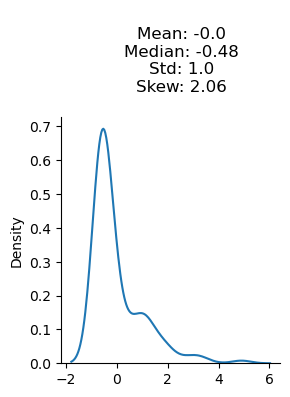

In [21]:
object= StandardScaler() 
std_df_guild_wins = object.fit_transform(df_guild_wins_acc[['contribution']])
sns.displot(std_df_guild_wins, height=3, legend=False, kind='kde').set(title=custom_title(std_df_guild_wins));

#### Square Root

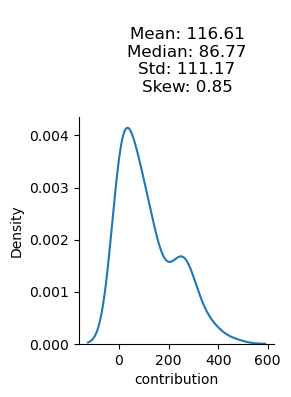

In [22]:
sqrt_df_guild_wins = np.sqrt(df_guild_wins_acc['contribution'])
sns.displot(sqrt_df_guild_wins, height=3, kind='kde').set(title=custom_title(sqrt_df_guild_wins));

#### Log Normal

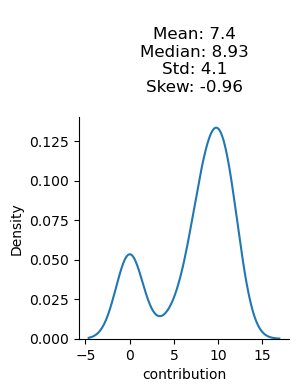

In [23]:
log_df_guild_wins = np.log1p(df_guild_wins_acc['contribution'])
sns.displot(log_df_guild_wins, height=3, kind='kde').set(title=custom_title(log_df_guild_wins));

The 2 distinct "bumps" might indicate bimodality, which means that binary split would be a rational decision.

Nevertheless, seeing this behaviour, I might as well try to remove 'zero' contributions to see if I can force normality on the remaining (non-zero) part of the distribution.

#### Log Normal + zero contributions excluded

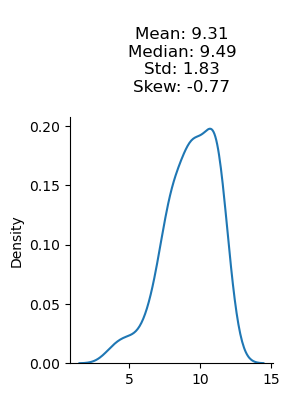

In [24]:
sns.displot(np.where(log_df_guild_wins==0, np.nan, log_df_guild_wins), height=3, kind='kde').set(title=custom_title(np.where(log_df_guild_wins==0, np.nan, log_df_guild_wins)));

#### Q-Q Plot of Log Normal + zero contributions excluded

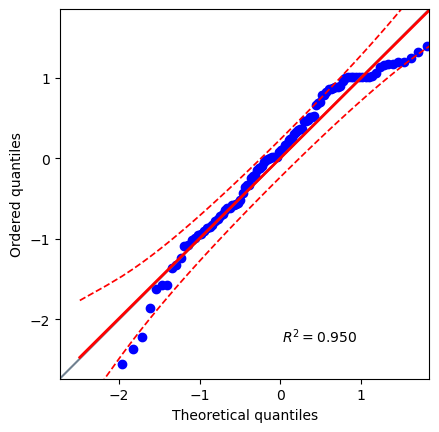

In [25]:
pg.qqplot(np.where(log_df_guild_wins==0, np.nan, log_df_guild_wins));

#### Shapiro-Wilk test for Normality of Log Normal + zero contributions excluded

In [26]:
pg.normality(np.where(log_df_guild_wins==0, np.nan, log_df_guild_wins))

,W,pval,normal
0,0.95,0.00,False


The above assessments prove that the data cannot be made approximately normal. Therefore, I will proceed to the Kruskal-Wallis H-test.

### Kruskal-Wallis H-test
    
    Hypothesis Statement:

    H0: There is no difference in Contribution between Guild Ranks
    H1: There is difference in Contribution between Guild Ranks
    
    alpha = 0.05

In [27]:
pg.kruskal(data=df_guild_wins_acc, dv='contribution', between='guild_rank')

,Source,ddof1,H,p-unc
Kruskal,guild_rank,6,57.03,0.00


#### H-test Summary
- __p-value__ shows the differences are __statistically significant__ at the alpha = 0.05;
- __H__ of ~57 indicates the existence of of large differences.

Now, I will proceed with a Post-Hoc test, to explore which rank pairs have different contribution distributions. For this purpose, the Dunn's test + Bonferroni Correction will be used.

### Post-Hoc Dunn's Test with Bonferroni Correction

In [28]:
posthoc_rank_contrib = posthoc_dunn(
    a=df_guild_wins_acc,
    group_col='guild_rank',
    val_col='contribution', 
    p_adjust='bonferroni'
)

In [29]:
nan_mask = lambda x: x if x < 0.05 else np.nan
nan_color = lambda x: f"color: white;" if np.isnan(x) else None

posthoc_rank_contrib.map(nan_mask).style.map(func=nan_color).format(precision=3)

,1,2,3,4,5,6,7
1,nan,nan,nan,0.001,0.000,0.000,0.001
2,nan,nan,nan,nan,0.003,0.007,0.014
3,nan,nan,nan,nan,0.003,0.011,0.022
4,0.001,nan,nan,nan,nan,nan,nan
5,0.000,0.003,0.003,nan,nan,nan,nan
6,0.000,0.007,0.011,nan,nan,nan,nan
7,0.001,0.014,0.022,nan,nan,nan,nan


The p-values (those that are visible) in the table above are less than the significance level alpha=0.05.

Next, I am going to filter out non-significant differences and display compared pairs of ranks for improved readability.

In [30]:
posthoc_rank_contrib_pval = (
    posthoc_rank_contrib
    .where(np.isnan(posthoc_rank_contrib.map(nan_mask))==False)
    .stack()
    .reset_index()
)
posthoc_rank_contrib_pval

,level_0,level_1,0
0,1,4,0.00
1,1,5,0.00
2,1,6,0.00
3,1,7,0.00
4,2,5,0.00
5,2,6,0.01
6,2,7,0.01
7,3,5,0.00
8,3,6,0.01
9,3,7,0.02


In [31]:
posthoc_rank_contrib_pval.columns = ['group_1','group_2','p_value']

# Exclude repeating pairs
posthoc_rank_contrib_pval = posthoc_rank_contrib_pval[posthoc_rank_contrib_pval['group_1'] < posthoc_rank_contrib_pval['group_2']]
# Exclude p-value column
posthoc_rank_contrib_pval = posthoc_rank_contrib_pval.iloc[:,:2]
# Add column with distance in "ranks" between significantly different results
posthoc_rank_contrib_pval['rank_distance'] = (posthoc_rank_contrib_pval['group_2']-posthoc_rank_contrib_pval['group_1'])
# Sort by rank distance
posthoc_rank_contrib_pval = posthoc_rank_contrib_pval.sort_values('rank_distance').reset_index(drop=True)

posthoc_rank_contrib_pval

,group_1,group_2,rank_distance
0,3,5,2
1,1,4,3
2,2,5,3
3,3,6,3
4,1,5,4
5,2,6,4
6,3,7,4
7,1,6,5
8,2,7,5
9,1,7,6


In [32]:
posthoc_rank_contrib_pval['rank_distance'].agg(['min','max','mean','median'])

min      2.00
max      6.00
mean     3.90
median   4.00
Name: rank_distance, dtype: float64

#### Post-Hoc Summary

Some of the results show statistically significant differences mostly between the lowest and the highest ranks (e.g. Rank 1 vs Rank 7). This suggests that, in general, characters at the opposite sides of the guild hierarchy have different contribution levels. On the other hand, ranks which are closer to each other, have less differences in contributions. 

The above mentioned effect, of distributions similarity, can be observed for nearly every rank, and ~3 or more ranks below or above them. The only exception being the difference between Rank 3 and Rank 5, which are relatively close (2 ranks) to each other. The "jump" can be partially explained by the fact that rank 5 is considered to be the first "officer" rank within a guild. However, it is not a game mechanic, but rather a widely accepted player standard, hinting that there could be some other factors, driving the changes. 

Noticeably, the Rank 4 did not show statistically significant differences when being compared to most of the other ranks (2, 3, 5, 6, or 7). This could suggest that rank 4 distribution of contribution values is overall representative of a central tendency within the guild. Thus, potentially providing a baseline for the contribution assesment across guild ranks.

## Expected vs Observed Contribution

The results so far display some degree of meaningful differences between ranks. However, without temporal data that would show order of events (progress of each player), an analysis of "which variable influences the other" could lead to a circular reasoning. In other words, "Does high contribution lead to guild rank promotions?", or "Does the promotion in guild rank enable players to contribute more?".

The `guild_rank` variable assumes hierarchy/order. And, as rank increases the contribution is expected to increase as well, i.e. players at lower ranks are expected to contribute less compared to those at higher ranks. However, as had been seen during EDA, certain ranks do not follow the expected trend of contribution. 

Therefore, given the zero-inflated nature of the contribution variable, I will focus on calculating the expected proportions of zero and non-zero contributions, at each guild rank. For this I will use logistic regression, encoding `contribution` variable as binary (__contribution > zero__ encoded as `1`, __contribution = zero__ encoded as `0`). After that, I will compare the observed contribution probability with the expected one.

Based on the previous statements, the variables for the logistic regression are:
- `contribution` (dependent y, binary)
- `guild_rank` (independent x, categorical ordinal)

##### How can the regression results be used?
1. To establish a baseline measurement, which in future analyses, would allow to compare baseline/expected proportions to the observed ones, thus potentially showing positive or negative changes in contribution across guild ranks. This will also prevent unfounded assumptions regarding expected contribution at each rank.  

2. To uncover insights by comparing observed and expected results. This could potentially increase awareness among guild officers and leaders, therefore leading to better encouragement campaigns or tailored events, in order to keep players at certain ranks more engaged. On the other hand, it might also show which ranks perform better than expected, allowing to explore existing factors that positively influence contribution.

In [33]:
zero_contribution_p = (df_guild_wins_acc['contribution'] == 0).mean()
print(f"Proportion of zeros: {zero_contribution_p*100:.0f}%")

Proportion of zeros: 21%


This large proportion of zero contributions is the reason for that bonimial-like distribution I got when applying log transform to `contribution` variable, which reinforces the decision to use logistic regresison with dichotomous `contribution`.

In [34]:
# Assigning new column with binary contribution variable
df_guild_wins_acc = df_guild_wins_acc.assign(contribution_b = (df_guild_wins_acc['contribution'] > 0).astype(int)) 
df_guild_wins_acc.sample(5)

,guild_rank,contribution,contribution_b
60,1,7479,1
8,4,5077,1
98,2,102,1
4,1,0,0
77,1,0,0


In [35]:
# Calculating proportions of contribution greater than 0, for each rank
zero_contribution_p_ranks = df_guild_wins_acc.groupby('guild_rank', as_index=False).agg(size=('guild_rank', 'size'), contribution_pp=('contribution_b', 'mean'))

#Calculating differences between proportions  
zero_contribution_p_ranks['contribution_pp_diff'] = zero_contribution_p_ranks['contribution_pp'].diff().fillna(0)

# Improving table readability 
(
    zero_contribution_p_ranks
    .style.map(func=lambda x: 'color:red;' if x < 0 else None)
    .format({'contribution_pp': '{:.1%}','contribution_pp_diff': '{:.1%}'})
)

,guild_rank,size,contribution_pp,contribution_pp_diff
0,1,22,40.9%,0.0%
1,2,19,78.9%,38.0%
2,3,27,70.4%,-8.6%
3,4,28,96.4%,26.1%
4,5,29,93.1%,-3.3%
5,6,8,100.0%,6.9%
6,7,3,100.0%,0.0%


Interestingly enough, there are some inconsistencies in the observed contribution proportions as the guild rank increases. Ranks 3 and 5, have a smaller proportion of non-zero contribution than preceeding ranks.

There is, in general, an upward trend in `contribution_pp` as `guild_rank` increases.

The top ranks, as expected, do not have any zero contributions. Although the group sizes here are small, it is reasonable to assume that the highest ranking players have accumulated a substantial amount of contributions, i.e. greater than zero.  

The first rank, having the largest proportion of players who haven't made any contribution (nearly 60%), should probably not be an alarming insight. The newcomers are less likely to actively invest their resources into a guild they just joined.

In [36]:
np.unique((df_guild_wins_acc['contribution'] > 0).astype(int))

array([0, 1])

#### Logistic Regression (important notice)
The logistic regression resluts show __odds__ (not probability) of a positive outcome. This translates to `contribution ≠ 0` relative to `contribution = 0` in the current analysis. 

Odds will be later converted into probabilities through some additional manipulations.

#### Logistic Regression: y=contribution (binary), x=guild_rank (ordinal) 

In [37]:
model_ordinal = smf.logit("contribution_b ~ guild_rank", data=df_guild_wins_acc).fit()
print(model_ordinal.summary())

Optimization terminated successfully.
         Current function value: 0.408587
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:         contribution_b   No. Observations:                  136
Model:                          Logit   Df Residuals:                      134
Method:                           MLE   Df Model:                            1
Date:                Sun, 03 Aug 2025   Pseudo R-squ.:                  0.1964
Time:                        13:40:00   Log-Likelihood:                -55.568
converged:                       True   LL-Null:                       -69.149
Covariance Type:            nonrobust   LLR p-value:                 1.870e-07
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -1.0147      0.507     -2.000      0.045      -2.009      -0.020
guild_rank     0.8183      0.

In [38]:
np.exp(model_ordinal.params)

Intercept    0.36
guild_rank   2.27
dtype: float64

In [39]:
rank_values = pd.DataFrame({'guild_rank': [1, 2, 3, 4, 5, 6, 7]})

# Get predictions with confidence intervals
predictions = model_ordinal.get_prediction(rank_values)
pred_summary = predictions.summary_frame(alpha=0.05)  # 95% CI

pred_summary

,predicted,se,ci_lower,ci_upper
0,0.45,0.09,0.29,0.62
1,0.65,0.06,0.53,0.75
2,0.81,0.04,0.72,0.87
3,0.91,0.03,0.82,0.95
4,0.96,0.02,0.89,0.98
5,0.98,0.01,0.93,0.99
6,0.99,0.01,0.95,1.00


In [40]:
zero_contribution_p_ranks.head(1)

,guild_rank,size,contribution_pp,contribution_pp_diff
0,1,22,0.41,0.00


In [41]:
df_log_reg_comparison = zero_contribution_p_ranks.merge(pred_summary, left_index=True, right_index=True)
df_log_reg_comparison

,guild_rank,size,contribution_pp,contribution_pp_diff,predicted,se,ci_lower,ci_upper
0,1,22,0.41,0.00,0.45,0.09,0.29,0.62
1,2,19,0.79,0.38,0.65,0.06,0.53,0.75
2,3,27,0.70,-0.09,0.81,0.04,0.72,0.87
3,4,28,0.96,0.26,0.91,0.03,0.82,0.95
4,5,29,0.93,-0.03,0.96,0.02,0.89,0.98
5,6,8,1.00,0.07,0.98,0.01,0.93,0.99
6,7,3,1.00,0.00,0.99,0.01,0.95,1.00


#### Model Validation
In order to check if the ordinal logistic regression predictions (expected values) align with the actual data, I will perform a Goodness of Fit test.

***

$$\chi^2 = \sum_{i=1}^{k} \frac{(O_i - E_i)^2}{E_i}$$

where:
- $O_i$ = observed frequency (number of players) for category (guild rank) $i$
- $E_i$ = expected frequency (number of players) for category (guild rank) $i$ 
- $k$ = number of categories (guild ranks)
- $df = k - 1 - p$, where $p$ = number of parameters estimated from the data

***
    Hypothesis Statement:

    H0: p > 0.05, Observed frequencies match expected frequencies from the model
    H1: p < 0.05, Observed frequencies don't match expected frequencies from the model
    
    alpha = 0.05

In [42]:
# Frequencies (counts)
observed_counts = df_log_reg_comparison["size"] * df_log_reg_comparison["contribution_pp"]
expected_counts = df_log_reg_comparison["size"] * df_log_reg_comparison["predicted"]

# Chi-Square test for Goodness of Fit
chi_squared = np.sum((observed_counts - expected_counts)**2 / expected_counts)

# 7 ranks (categories) - 2 parameters (b0, b1)
df = 7 - 2
p_value = 1 - chi2.cdf(chi_squared, df)
p_value

0.9500490861639862

In [43]:
"Valid Model" if p_value > 0.05 else "Model Not Valid"

'Valid Model'

According to the results above, __Observed frequencies match expected frequencies from the model__, at alpha=0.05 

#### Results Visualization

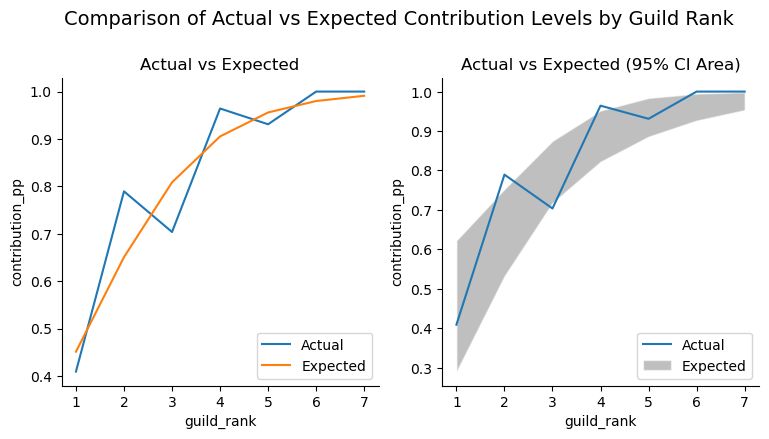

In [44]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(9,4))

fig.suptitle('Comparison of Actual vs Expected Contribution Levels by Guild Rank', fontsize=14, y=1.05)

ax1.set_title('Actual vs Expected')
sns.lineplot(df_log_reg_comparison, x='guild_rank', y='contribution_pp', ax=ax1, label='Actual')
sns.lineplot(df_log_reg_comparison, x='guild_rank', y='predicted', ax=ax1, label='Expected')
ax1.legend(loc='lower right')

ax2.set_title('Actual vs Expected (95% CI Area)')
sns.lineplot(df_log_reg_comparison, x='guild_rank', y='contribution_pp', ax=ax2, label='Actual')
ax2.fill_between(x=df_log_reg_comparison['guild_rank'], y1=df_log_reg_comparison['ci_lower'], y2=df_log_reg_comparison['ci_upper'], alpha=0.5, color='grey', edgecolor='white', aa=True, label='Expected')
ax2.legend(loc='lower right')

sns.despine()

In [45]:
def cond_color(i, text=False):
    _diffs = df_log_reg_comparison['contribution_pp_diff']
    _cont_pp = df_log_reg_comparison['contribution_pp']
    _cont_ci_l = df_log_reg_comparison['ci_lower']
    _cont_ci_u = df_log_reg_comparison['ci_upper']
    
    color=None
    # Custom background marker
    if text==False:   
        if _cont_pp[i] > _cont_ci_l[i] and _cont_pp[i] < _cont_ci_u[i]:
            color = (0, 0, 0, 0)
        elif _cont_pp[i] > _cont_ci_u[i]:
            color = (0, 0, 0, 0)
        elif _cont_pp[i] < _cont_ci_l[i] and _diffs[i] < 0:
            color = 'black'
    # Custom marker values
    else:
        if _cont_pp[i] > _cont_ci_l[i] and _cont_pp[i] < _cont_ci_u[i]:
            color = 'dimgrey'
        elif _cont_pp[i] > _cont_ci_u[i]:
            color = 'dimgrey'
        elif _cont_pp[i] < _cont_ci_l[i] and _diffs[i] < 0:
            color = 'black'  
             
    return color

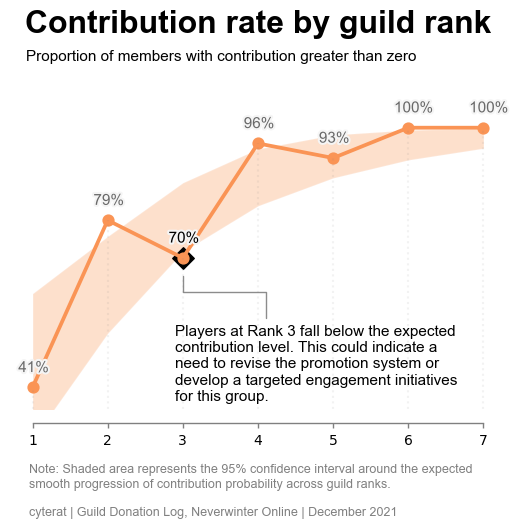

In [46]:
fig,ax = plt.subplots()

plt.title(
    "Contribution rate by guild rank",
    pad=0,
    y=1.02,
    x=0.03,
    loc='left',
    size=23,
    weight='bold',
    family='Arial'
)

plt.suptitle(
    "Proportion of members with contribution greater than zero",
    x=0.15,
    y=0.86,
    horizontalalignment='left',
    size=11,
    family='Arial'
)

sns.pointplot(
    df_log_reg_comparison,
    x='guild_rank',
    y='contribution_pp',
    color='#FA9455',
    ax=ax
)

ax.fill_between(
    x=df_log_reg_comparison['guild_rank']-1, 
    y1=df_log_reg_comparison['ci_lower'], 
    y2=df_log_reg_comparison['ci_upper'],
    alpha=0.2,
    color=nw_clr_single,
    edgecolor='white',
    aa=True,
    label='Expected'
)

for i, row in enumerate(df_log_reg_comparison.itertuples()):
    ax.text(
        x=row.guild_rank-1*1.19,
        y=row.contribution_pp+0.035,
        s=f"{row.contribution_pp*100:.0f}%",
        size=11,
        path_effects=[patheffects.withStroke(linewidth=3, foreground='#f5f5f5', capstyle="round")],
        family='Arial',
        color=cond_color(i,text=True)
    )
    ax.vlines(
        x=row.guild_rank-1,
        ymin=min(df_log_reg_comparison['contribution_pp'])-0.1,
        ymax=row.contribution_pp,
        colors='grey',
        linestyles='dotted',
        alpha=0.1
    )
    ax.scatter(
        x=row.guild_rank-1,
        y=row.contribution_pp,
        c=cond_color(i),
        marker='D',
        s=120
    )

plt.annotate(
    xy=(1.9, 0.38),
    text='Players at Rank 3 fall below the expected\ncontribution level. This could indicate a\nneed to revise the promotion system or\ndevelop a targeted engagement initiatives\nfor this group.',
    size=11,
    family='Arial'
)

plt.annotate(
    "",
    xy=(3.1, 0.56), # annotation text
    xytext=(2, 0.67), # marker
    arrowprops=dict(arrowstyle="-", color='grey', connectionstyle="bar, angle=180, fraction=0.2", alpha=0.9),
    family='Arial'
)

fig.text(
    x=0.155,
    y=-0.110,
    s='Note: Shaded area represents the 95% confidence interval around the expected\nsmooth progression of contribution probability across guild ranks.\n\ncyterat | Guild Donation Log, Neverwinter Online | December 2021',
    size=9,
    family='Arial',
    color='grey'
)

ax.set_ylim(bottom=min(df_log_reg_comparison['contribution_pp'])-0.05, top=1.2)
ax.set(xlabel=None)

ax.spines['bottom'].set_linewidth(1)
ax.spines['bottom'].set_color('grey')
ax.tick_params(width=1,color='grey')

plt.gca().get_yaxis().set_visible(False)

sns.despine(left=True, offset=10, trim=True)

# plt.savefig('contribution-rank.svg', dpi=450, bbox_inches='tight', facecolor='#f5f5f5', transparent=True, pad_inches=0.2)

plt.show()

#### Summary

The probabilities of not having contribution equal to zero are clearly rising as players progress through guild ranks. 

The baseline contribution rates for rank 1 are currently at 40%. Players at this rank are not expected to invest their resources, as they only begin to get themselves acquainted with the guild. The existance of any contributions at all at this rank, might indicate a proactiveness of players, worth paying attention to, in order to ensure a timely promotion.  

A nearly twofold increase, can be observed at rank 2, which is considerably higher than expected. Such anomaly could be explained by, including but not limited to, the "first promotion effect" or a decision to stick with the guild after the 'trial' period. It is worth noting that the expected interval, shown on the visuzlization as a shaded area, was calculated based on a single month data, so it might slightly change when more data becomes available in the future.

Rank 3 shows a noticeable drop in contribution proportions, which, although expected as the newcomer effects fade, is an indicator of potential factors that hinder or discourage further growth. Several possible issues might include: 
- lack of a clear rank advancement roadmap;
- small or non-extistent benefits of higher ranks, i.e. lack of motivation to progress further;
- existence of an excessive number of perks, leading to stagnation.

It is worth noting a slightly irregular level of contribution at rank 5, which does seem to fall behind compared to it's neighbouring ranks. Still, this is within the expected interval.   

A plateau, at nearly 100%, is observed to form, strarting at 'officer' ranks. This is a natural effect, as players are expected to have contribution > 0 by the time they reach the highest ranks. 

#### Usage Examples

The table below is useful by itself. 

It allows (_assuming the overall state of the guild remains relatively the same_) to calculate the approximate number of players that are expected to have contributed, given the total number of players of that rank. 

$$E_i = n_i \times \hat{p}_i$$

where:
- $E_i$ = expected number of contributors in rank $i$
- $n_i$ = total number of players in rank $i$
- $\hat{p}_i$ = predicted probability of contribution for rank $i$ (from table below)

In [47]:
df_log_reg_comparison

,guild_rank,size,contribution_pp,contribution_pp_diff,predicted,se,ci_lower,ci_upper
0,1,22,0.41,0.00,0.45,0.09,0.29,0.62
1,2,19,0.79,0.38,0.65,0.06,0.53,0.75
2,3,27,0.70,-0.09,0.81,0.04,0.72,0.87
3,4,28,0.96,0.26,0.91,0.03,0.82,0.95
4,5,29,0.93,-0.03,0.96,0.02,0.89,0.98
5,6,8,1.00,0.07,0.98,0.01,0.93,0.99
6,7,3,1.00,0.00,0.99,0.01,0.95,1.00


_Exmaple 1_: __How many players of Rank 4 are expected to have contributed at least once, if the current number of players there is 53?__

In [48]:
rank_population = 53
rank_of_interest = 4

row = df_log_reg_comparison[df_log_reg_comparison['guild_rank']==rank_of_interest]

expected_n_players = np.floor(rank_population * row['predicted'])

print(f"Expected number of players with at least one contribution is {int(expected_n_players)}.")

Expected number of players with at least one contribution is 47.


_Exmaple 2_: __If we recruit 15 new Rank 1 players, how many of them are expected to contribute?__

In [49]:
rank_population = 15
rank_of_interest = 1

row = df_log_reg_comparison[df_log_reg_comparison['guild_rank']==rank_of_interest]

expected_n_players = np.floor(rank_population * row['predicted'])

print(f"Expected number players with at least one contribution is {int(expected_n_players)}.")

Expected number players with at least one contribution is 6.


_Exmaple 3_: __I think Rank 5 is underperforming. Currently there are 64 players, but only 40 have contributed. What is the lowest expected number of contributors that rank should have?__

In [50]:
rank_population = 64
rank_of_interest = 5

row = df_log_reg_comparison[df_log_reg_comparison['guild_rank']==rank_of_interest]

expected_n_players = np.floor(rank_population * row['ci_lower']) # changed column here

print(f"Expected lowest number of players with at least one contribution is {int(expected_n_players)}.")

Expected lowest number of players with at least one contribution is 56.
